In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from simulation_code.tissue_model import acuity_source
from simulation_code.utils import simulate_acoustic

from jwave.geometry import Domain, Medium, TimeAxis

from simulation_code.load_model import load_model_from_excel

from itertools import product

os.environ["PA_SIM_EXTRAPOLATE"] = "0"

In [2]:
FAST_DEMO_MODE = (
    # for fast demo mode, we only run a single wavelength and one oxygenation.
    True
)

# These parameters will be used for MCX simulation.
nx, ny, nz = 668, 400, 300
dx = 0.06  # mm

# Wavelengths to get reflectance measurements at.
WAVELENGTHS = np.arange(700, 920, 20)
if FAST_DEMO_MODE:
    WAVELENGTHS = WAVELENGTHS[:1]

# Artery blood oxygenations.
OXYGENATIONS = np.linspace(0, 1, 11)
if FAST_DEMO_MODE:
    OXYGENATIONS = OXYGENATIONS[:1]

# Melanosome volume fractions: varied logarithmically.
mvfs = np.logspace(np.log10(0.02), np.log10(0.4), 6)
if FAST_DEMO_MODE:
    mvfs = mvfs[:1]

# The six simulation parameters are assigned to the Fitzpatrick scale.
fps = ["I", "II", "III", "IV", "V", "VI"]

# Speed of sound
c = 1500
# Sampling frequency
fs = 4e7
artery_oxygenation = [1]
vein_oxygenation = [0.7]

In [3]:
def run_simulations_all(
    p0_data,
    p0_all,
    domain: Domain,
    medium: Medium,
    time_axis: TimeAxis,
    geometry,
    cz=10e-3,
):
    results = []
    for p0 in tqdm(p0_all, desc=" wavelength loop", position=1, leave=False):
        sd = simulate_acoustic(
            p0_data,
            p0,
            domain,
            medium,
            time_axis,
            geometry,
            cz)
        results.append(sd.T)
    return np.stack(results)

In [4]:
domain = Domain((512, 128, 256), (0.06 * 4e-3, 0.06 * 4e-3, 0.06 * 4e-3))
medium = Medium(domain=domain, sound_speed=c)
time_axis = TimeAxis(1 / fs, 0.06 / medium.sound_speed)

###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2022 Qianqian Fang <q.fang at neu.edu>          #
#                             http://mcx.space/                               #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
$Rev::      $v2022.10$Date::                       $ by $Author::             $
###############################################################################
- variant name: [Fermi] compiled by nvcc

 wavelength loop:   0%|          | 0/1 [00:00<?, ?it/s]

[172.0, 13.5, 23.333333333333329] [339.0, 113.5, 98.333333333333329]
(668, 400, 300) (167, 100, 75) (512, 128, 256)


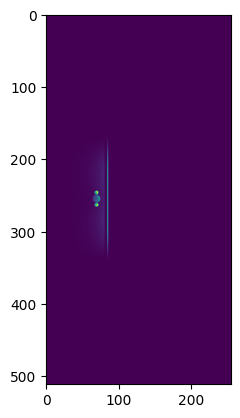

In [5]:
i = 0

for mvf, oxy, vein_oxy in product(mvfs, artery_oxygenation, vein_oxygenation):
    tissue_model = load_model_from_excel(
        "simulation_specification/forearm_tissue_model.xlsx",
        nx,
        ny,
        nz,
        dx,
        tissue_cz=-nz * dx / 3,
        variations=[("Epidermis", {"MelanosomeVolumeFraction": mvf})],
    )

    settings = {
        "artery_oxygenation": oxy,
        "mvf": mvf,
        "vein_oxygenation": vein_oxy}

    m = tissue_model.run_mcx(
        WAVELENGTHS,
        acuity_source(tissue_model),
        gpu_device=2)
    m.update(settings)

    # Load the detection geometry from NumPy file.
    geometry = np.load("../data/acuity_geometry.npz")["geom"]
    geometry[:, 2] -= 8e-3

    p0_data = dict(
        geom=geometry,
        dx_mm=tissue_model.dx_mm,
        r0=tissue_model.r_0,
        n=np.array(tissue_model.n),
    )
    p0_data.update(m)
    p0_raw = p0_data["p0"]
    time_series = run_simulations_all(
        p0_data, p0_raw, domain, medium, time_axis, geometry
    )
    if not FAST_DEMO_MODE:
        np.savez(
            f"../data/simulations/acoustic_melanosome_realistic_{str(i).zfill(3)}",
            ts=time_series,
            geometry=geometry,
            fs=fs,
            c=c,
            wavelength=p0_data["wavelength"],
            artery_ox=oxy,
            mvf=mvf,
            vein_ox=vein_oxy,
            mua=m["mua"][0, :, m["mua"].shape[2] // 2],
            p0=m["p0"][0, :, m["p0"].shape[2] // 2],
            seg=m["seg"][0, :, m["seg"].shape[2] // 2],
        )
    else:
        np.savez(
            f"../data/simulations/demo_acoustic_melanosome_realistic_{str(i).zfill(3)}",
            ts=time_series,
            geometry=geometry,
            fs=fs,
            c=c,
            wavelength=p0_data["wavelength"],
            artery_ox=oxy,
            mvf=mvf,
            vein_ox=vein_oxy,
            mua=m["mua"][0, :, m["mua"].shape[2] // 2],
            p0=m["p0"][0, :, m["p0"].shape[2] // 2],
            seg=m["seg"][0, :, m["seg"].shape[2] // 2],
        )
    i += 1

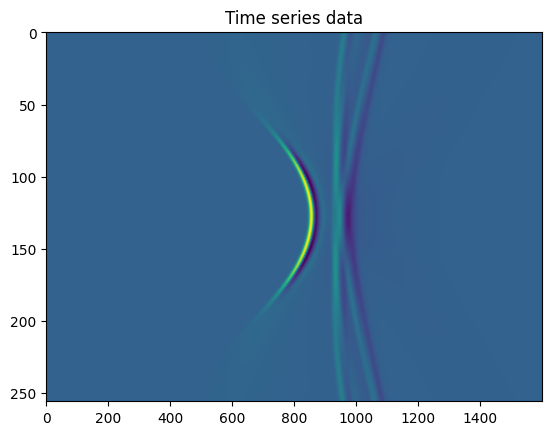

In [6]:
plt.imshow(time_series[0], aspect="auto")
plt.title("Time series data")
plt.show()